In [1]:
%tensorflow_version 2.x
import random as rn
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

TensorFlow 2.x selected.


In [0]:

# Loading data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

height = 28
width = 28
n_channel = 1

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape(x_train.shape[0], height, width, n_channel)
x_test = x_test.reshape(x_test.shape[0], height, width, n_channel)



In [0]:
def quantise(images, q_levels):
    """Quantise image into q levels"""
    return (np.digitize(images, np.arange(q_levels) / q_levels) - 1).astype('float32')

# Quantise the input data in q levels
q_levels = 4
x_train_quantised = quantise(x_train, q_levels)
x_test_quantised = quantise(x_test, q_levels)

In [0]:
# Creating input stream using tf.data API
batch_size = 128
train_buf = 60000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_quantised / (q_levels - 1),
                                                    x_train_quantised.astype('int32'),
                                                    y_train))
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_quantised / (q_levels - 1),
                                                   x_test_quantised.astype('int32'),
                                                   y_test))
test_dataset = test_dataset.batch(batch_size)

In [0]:
class MaskedConv2D(tf.keras.layers.Layer):
    """Convolutional layers with masks for autoregressive models

    Convolutional layers with simple implementation to have masks type A and B.
    """

    def __init__(self,
                 mask_type,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros'):
        super(MaskedConv2D, self).__init__()

        assert mask_type in {'A', 'B', 'V'}
        self.mask_type = mask_type

        self.filters = filters

        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        self.kernel_size = kernel_size

        self.strides = strides
        self.padding = padding.upper()
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)

    def build(self, input_shape):
        kernel_h, kernel_w = self.kernel_size

        self.kernel = self.add_weight("kernel",
                                      shape=(kernel_h,
                                             kernel_w,
                                             int(input_shape[-1]),
                                             self.filters),
                                      initializer=self.kernel_initializer,
                                      trainable=True)

        self.bias = self.add_weight("bias",
                                    shape=(self.filters,),
                                    initializer=self.bias_initializer,
                                    trainable=True)

        mask = np.ones(self.kernel.shape, dtype=np.float32)
        if self.mask_type == 'V':
            mask[kernel_h // 2:, :, :, :] = 0.
        else:
            mask[kernel_h // 2, kernel_w // 2 + (self.mask_type == 'B'):, :, :] = 0.
            mask[kernel_h // 2 + 1:, :, :] = 0.

        self.mask = tf.constant(mask, dtype=tf.float32, name='mask')

    def call(self, input):
        masked_kernel = tf.math.multiply(self.mask, self.kernel)
        x = tf.nn.conv2d(input, masked_kernel, strides=[1, self.strides, self.strides, 1], padding=self.padding)
        x = tf.nn.bias_add(x, self.bias)
        return x


In [0]:
class GatedBlock(tf.keras.Model):
    """"""

    def __init__(self, mask_type, filters, kernel_size):
        super(GatedBlock, self).__init__(name='')

        self.mask_type = mask_type
        self.vertical_conv = MaskedConv2D(mask_type='V', filters=2 * filters, kernel_size=kernel_size)
        self.horizontal_conv = MaskedConv2D(mask_type=mask_type, filters=2 * filters, kernel_size=(1, kernel_size))
        self.v_to_h_conv = keras.layers.Conv2D(filters=2 * filters, kernel_size=1)

        self.horizontal_output = keras.layers.Conv2D(filters=filters, kernel_size=1)

        self.cond_fc_h = keras.layers.Dense(2 * filters, use_bias=False)
        self.cond_fc_v = keras.layers.Dense(2 * filters, use_bias=False)

    def _gate(self, x):
        tanh_preactivation, sigmoid_preactivation = tf.split(x, 2, axis=-1)
        return tf.nn.tanh(tanh_preactivation) * tf.nn.sigmoid(sigmoid_preactivation)

    def call(self, input_tensor):
        v = input_tensor[0]
        h = input_tensor[1]
        y = input_tensor[2]

        y = tf.one_hot(y, 10)
        codified_h = tf.expand_dims(tf.expand_dims(self.cond_fc_h(y), 1), 1)
        codified_v = tf.expand_dims(tf.expand_dims(self.cond_fc_v(y), 1), 1)

        horizontal_preactivation = self.horizontal_conv(h)  # 1xN
        vertical_preactivation = self.vertical_conv(v)  # NxN
        v_to_h = self.v_to_h_conv(vertical_preactivation)  # 1x1
        vertical_preactivation = vertical_preactivation+codified_v
        v_out = self._gate(vertical_preactivation)

        horizontal_preactivation = horizontal_preactivation + v_to_h
        horizontal_preactivation = horizontal_preactivation + codified_h
        h_activated = self._gate(horizontal_preactivation)

        if self.mask_type == 'A':
            h_out = h_activated
        elif self.mask_type =='B':
            h_out = self.horizontal_output(h_activated)
            h_out = h + h_out

        return v_out, h_out

In [0]:
inputs = keras.layers.Input(shape=(height, width, n_channel))
labels = keras.layers.Input(shape=(), dtype=tf.int32)

v, h = GatedBlock(mask_type='A', filters=64, kernel_size=7)([inputs, inputs, labels])

for i in range(7):
    v, h = GatedBlock(mask_type='B', filters=64, kernel_size=3)([v, h, labels])

x = keras.layers.Activation(activation='relu')(h)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)

x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=n_channel * q_levels, kernel_size=1, strides=1)(x)  # shape [N,H,W,DC]

pixelcnn = tf.keras.Model(inputs=[inputs, labels], outputs=x)


In [0]:
# Prepare optimizer and loss function
lr_decay = 0.9999
learning_rate = 5e-3
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

compute_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [0]:
@tf.function
def train_step(batch_x, batch_y, batch_label):
    with tf.GradientTape() as ae_tape:
        logits = pixelcnn([batch_x, batch_label], training=True)

        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])  # shape [N,H,W,DC] -> [N,H,W,D,C]
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])  # shape [N,H,W,D,C] -> [N,H,W,C,D]

        loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    gradients = ae_tape.gradient(loss, pixelcnn.trainable_variables)
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    optimizer.apply_gradients(zip(gradients, pixelcnn.trainable_variables))

    return loss

In [10]:
# Training loop
n_epochs = 50
n_iter = int(np.ceil(x_train_quantised.shape[0] / batch_size))
for epoch in range(n_epochs):
    start_epoch = time.time()
    for i_iter, (batch_x, batch_y, batch_label) in enumerate(train_dataset):
        start = time.time()
        optimizer.lr = optimizer.lr * lr_decay
        loss = train_step(batch_x, batch_y, batch_label)
        iter_time = time.time() - start
        if i_iter % 100 == 0:
            print('EPOCH {:3d}: ITER {:4d}/{:4d} TIME: {:.2f} LOSS: {:.4f}'.format(epoch,
                                                                                   i_iter, n_iter,
                                                                                   iter_time,
                                                                                   loss))
    epoch_time = time.time() - start_epoch
    print('EPOCH {:3d}: TIME: {:.2f} ETA: {:.2f}'.format(epoch,
                                                         epoch_time,
                                                         epoch_time * (n_epochs - epoch)))



EPOCH   0: ITER    0/ 469 TIME: 4.71 LOSS: 1.3942
EPOCH   0: ITER  100/ 469 TIME: 0.12 LOSS: 0.1780
EPOCH   0: ITER  200/ 469 TIME: 0.13 LOSS: 0.1610
EPOCH   0: ITER  300/ 469 TIME: 0.12 LOSS: 0.1598
EPOCH   0: ITER  400/ 469 TIME: 0.12 LOSS: 0.1499
EPOCH   0: TIME: 65.28 ETA: 3264.07
EPOCH   1: ITER    0/ 469 TIME: 0.02 LOSS: 0.1432
EPOCH   1: ITER  100/ 469 TIME: 0.12 LOSS: 0.1451
EPOCH   1: ITER  200/ 469 TIME: 0.12 LOSS: 0.1462
EPOCH   1: ITER  300/ 469 TIME: 0.09 LOSS: 0.1460
EPOCH   1: ITER  400/ 469 TIME: 0.12 LOSS: 0.1411
EPOCH   1: TIME: 58.96 ETA: 2889.17
EPOCH   2: ITER    0/ 469 TIME: 0.02 LOSS: 0.1419
EPOCH   2: ITER  100/ 469 TIME: 0.12 LOSS: 0.1393
EPOCH   2: ITER  200/ 469 TIME: 0.12 LOSS: 0.1397
EPOCH   2: ITER  300/ 469 TIME: 0.12 LOSS: 0.1377
EPOCH   2: ITER  400/ 469 TIME: 0.08 LOSS: 0.1401
EPOCH   2: TIME: 58.85 ETA: 2824.79
EPOCH   3: ITER    0/ 469 TIME: 0.02 LOSS: 0.1406
EPOCH   3: ITER  100/ 469 TIME: 0.12 LOSS: 0.1438
EPOCH   3: ITER  200/ 469 TIME: 0.17 LOSS:

In [0]:
samples = np.zeros((9, height, width, n_channel), dtype='float32')
samples_labels = (np.ones((9)) * 2).astype('int32')
for i in range(height):
    for j in range(width):
        logits = pixelcnn([samples, samples_labels])
        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])  # shape [N,H,W,DC] -> [N,H,W,D,C]
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])  # shape [N,H,W,D,C] -> [N,H,W,C,D]
        next_sample = tf.random.categorical(logits[:, i, j, 0, :], 1)
        samples[:, i, j, 0] = (next_sample.numpy() / (q_levels - 1))[:, 0]



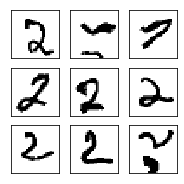

In [14]:

fig = plt.figure(figsize=(3, 3))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()


In [0]:
samples = np.zeros((9, height, width, n_channel), dtype='float32')
samples_labels = (np.ones((9)) * 5).astype('int32')
for i in range(height):
    for j in range(width):
        logits = pixelcnn([samples, samples_labels])
        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])  # shape [N,H,W,DC] -> [N,H,W,D,C]
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])  # shape [N,H,W,D,C] -> [N,H,W,C,D]
        next_sample = tf.random.categorical(logits[:, i, j, 0, :], 1)
        samples[:, i, j, 0] = (next_sample.numpy() / (q_levels - 1))[:, 0]



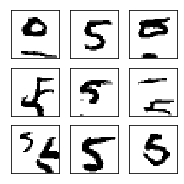

In [16]:

fig = plt.figure(figsize=(3, 3))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()
